In [1]:
# Imports
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_20newsgroups
from sklearn.decomposition import PCA

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from gensim.models import Word2Vec, FastText

In [2]:
# Download NLTK resources (run once per environment)
nltk.download("punkt")
nltk.download("stopwords")

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\VinceT\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\VinceT\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
# Load the dataset
# remove=... strips off headers/footers/quotes to reduce noise
data = fetch_20newsgroups(subset="train", remove=("headers", "footers", "quotes"))
documents = data.data

print("Number of documents:", len(documents))
print("\nExample document snippet:\n")
print(documents[0][:600])

Number of documents: 11314

Example document snippet:

I was wondering if anyone out there could enlighten me on this car I saw
the other day. It was a 2-door sports car, looked to be from the late 60s/
early 70s. It was called a Bricklin. The doors were really small. In addition,
the front bumper was separate from the rest of the body. This is 
all I know. If anyone can tellme a model name, engine specs, years
of production, where this car is made, history, or whatever info you
have on this funky looking car, please e-mail.


In [4]:
# Build stopword set once
stop_words = set(stopwords.words("english"))

def preprocess(text: str):
    """Convert raw text into a list of clean tokens.

    Steps:
    1) Lowercase
    2) Tokenize
    3) Keep alphabetic tokens only (drop numbers/punctuation)
    4) Remove stopwords

    Returns:
        List[str]: cleaned tokens
    """
    tokens = word_tokenize(text.lower())
    tokens = [t for t in tokens if t.isalpha() and t not in stop_words]  # isalpha() filters out non-alphabetic tokens
    return tokens

# Tokenize the full corpus
corpus = [preprocess(doc) for doc in documents]

# Quick sanity check
print("Tokens in first document (first 50):")
print(corpus[0][:50])

Tokens in first document (first 50):
['wondering', 'anyone', 'could', 'enlighten', 'car', 'saw', 'day', 'sports', 'car', 'looked', 'late', 'early', 'called', 'bricklin', 'doors', 'really', 'small', 'addition', 'front', 'bumper', 'separate', 'rest', 'body', 'know', 'anyone', 'tellme', 'model', 'name', 'engine', 'specs', 'years', 'production', 'car', 'made', 'history', 'whatever', 'info', 'funky', 'looking', 'car', 'please']


## Where does GloVe fit? (concept-only)
You learned in lecture that we can also build a **co-occurrence matrix** \(X\) and try to compress it.

Two major perspectives:
1. **Predictive models** (Word2Vec): learn by predicting context  
2. **Count-based global models** (GloVe): learn from aggregated co-occurrence statistics

GloVe aims to encode meaning using **ratios of co-occurrence probabilities**, and often shows strong linear structure (useful for analogies).

We do not train GloVe from scratch here because:
- it requires building and storing large co-occurrence statistics
- training is heavier than Word2Vec/FastText for an in-class lab

However, you should understand the core difference:
- Word2Vec: local prediction objective
- GloVe: global co-occurrence objective

**You will see GloVe again** when using pretrained embeddings in later weeks.


### Demonstrating the GloVe concept: Co-occurrence Matrix

Although we won't train GloVe from scratch, we can build a **co-occurrence matrix** to understand the core idea. This shows how GloVe differs from Word2Vec's prediction-based approach.

In [5]:
from collections import Counter, defaultdict

def build_cooccurrence_matrix(corpus, window=2, vocab_size=100):
    """
    Build a simple co-occurrence matrix from a corpus.
    
    This demonstrates what GloVe uses as input:
    - Count how often words appear together within a window
    - Store these counts in a matrix X where X[i,j] = count of word_j near word_i
    """
    # Build vocabulary from most common words
    word_counts = Counter(word for doc in corpus for word in doc)
    vocab = [word for word, _ in word_counts.most_common(vocab_size)]
    word_to_idx = {word: i for i, word in enumerate(vocab)}
    
    # Build co-occurrence counts
    cooccurrence = defaultdict(Counter)
    
    for doc in corpus:
        for i, center_word in enumerate(doc):
            if center_word not in word_to_idx:
                continue
            # Look at words within the window
            start = max(0, i - window)
            end = min(len(doc), i + window + 1)
            for j in range(start, end):
                if i != j and doc[j] in word_to_idx:
                    cooccurrence[center_word][doc[j]] += 1
    
    # Convert to matrix
    matrix = np.zeros((vocab_size, vocab_size))
    for word, neighbors in cooccurrence.items():
        i = word_to_idx[word]
        for neighbor, count in neighbors.items():
            j = word_to_idx[neighbor]
            matrix[i, j] = count
    
    return matrix, vocab, word_to_idx

# Build a small co-occurrence matrix
cooc_matrix, vocab_list, word_to_idx = build_cooccurrence_matrix(corpus, window=2, vocab_size=50)

print("Co-occurrence matrix shape:", cooc_matrix.shape)
print("\nTop 10 words in vocabulary:")
print(vocab_list[:10])

Co-occurrence matrix shape: (50, 50)

Top 10 words in vocabulary:
['would', 'one', 'x', 'max', 'people', 'like', 'get', 'know', 'also', 'q']


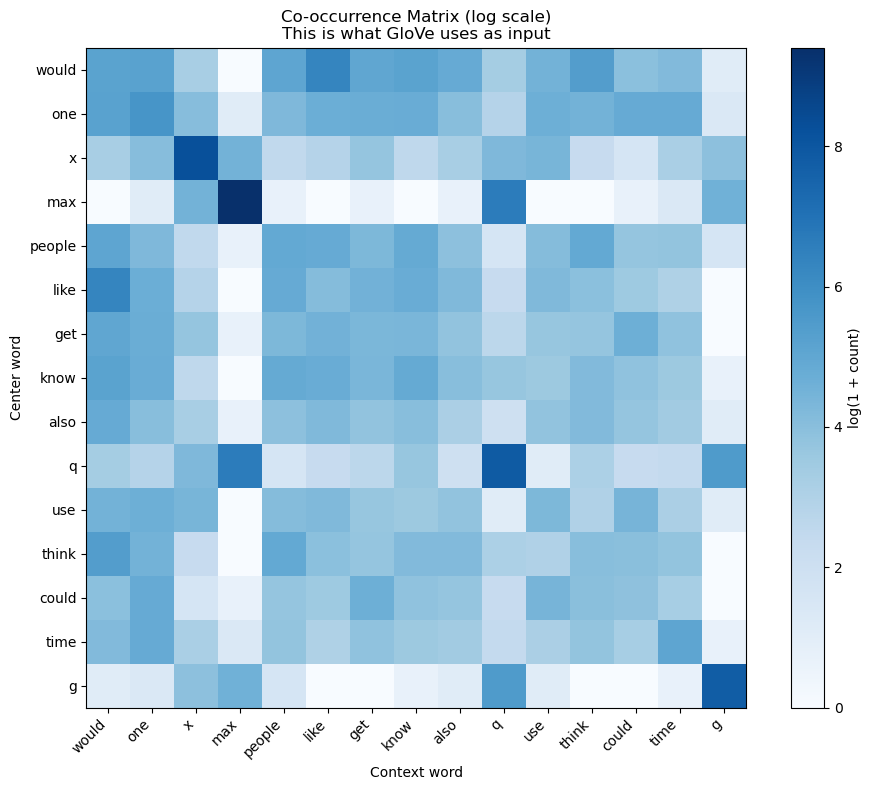


Key insight: GloVe learns embeddings by factorizing this co-occurrence matrix.
Word2Vec, by contrast, never explicitly builds this matrix — it learns via prediction.


In [6]:
# Visualize a portion of the co-occurrence matrix
import matplotlib.pyplot as plt

# Show co-occurrence for the first 15 words
subset_size = 15
subset_matrix = cooc_matrix[:subset_size, :subset_size]
subset_vocab = vocab_list[:subset_size]

plt.figure(figsize=(10, 8))
plt.imshow(np.log1p(subset_matrix), cmap='Blues')  # log1p for better visualization
plt.colorbar(label='log(1 + count)')
plt.xticks(range(subset_size), subset_vocab, rotation=45, ha='right')
plt.yticks(range(subset_size), subset_vocab)
plt.title("Co-occurrence Matrix (log scale)\nThis is what GloVe uses as input")
plt.xlabel("Context word")
plt.ylabel("Center word")
plt.tight_layout()
plt.show()

print("\nKey insight: GloVe learns embeddings by factorizing this co-occurrence matrix.")
print("Word2Vec, by contrast, never explicitly builds this matrix — it learns via prediction.")

In [7]:
# Demonstrate GloVe's key idea: co-occurrence probability ratios
def get_cooccurrence_prob(word, context, cooc_matrix, word_to_idx):
    """Calculate P(context | word) from co-occurrence counts."""
    if word not in word_to_idx or context not in word_to_idx:
        return 0.0
    i = word_to_idx[word]
    j = word_to_idx[context]
    row_sum = cooc_matrix[i].sum()
    if row_sum == 0:
        return 0.0
    return cooc_matrix[i, j] / row_sum

# Example: Compare how "computer" and "government" relate to different context words
probe_words = ["computer", "government"]
context_words = ["software", "system", "law", "president", "data"]

print("Co-occurrence probabilities P(context | word):")
print("-" * 60)
print(f"{'Context':<12}", end="")
for word in probe_words:
    print(f"{word:<15}", end="")
print("Ratio")
print("-" * 60)

for ctx in context_words:
    probs = []
    for word in probe_words:
        p = get_cooccurrence_prob(word, ctx, cooc_matrix, word_to_idx)
        probs.append(p)
        print(f"{p:<15.4f}", end="")
    # GloVe uses ratios to capture meaning
    ratio = probs[0] / probs[1] if probs[1] > 0 else float('inf')
    print(f"  {ctx:<12}{ratio:.2f}")

print("\n" + "=" * 60)
print("GloVe insight: Ratios reveal relationships!")
print("- Ratio >> 1: context word is more related to 'computer'")
print("- Ratio << 1: context word is more related to 'government'")
print("- Ratio ≈ 1: context word is equally related to both")

Co-occurrence probabilities P(context | word):
------------------------------------------------------------
Context     computer       government     Ratio
------------------------------------------------------------
0.0000         0.0000           software    inf
0.0000         0.0000           system      inf
0.0000         0.0000           law         inf
0.0000         0.0000           president   inf
0.0000         0.0000           data        inf

GloVe insight: Ratios reveal relationships!
- Ratio >> 1: context word is more related to 'computer'
- Ratio << 1: context word is more related to 'government'
- Ratio ≈ 1: context word is equally related to both


### Summary: Word2Vec vs GloVe

| Aspect | Word2Vec | GloVe |
|--------|----------|-------|
| **Approach** | Predictive (neural network) | Count-based (matrix factorization) |
| **Training objective** | Predict context words from center word | Minimize difference between dot product and log co-occurrence |
| **Uses global statistics?** | ❌ No — learns from local windows | ✅ Yes — uses entire corpus statistics |
| **Co-occurrence matrix** | Not explicitly built | Explicitly built and factorized |
| **Training speed** | Fast (online learning) | Slower (requires matrix construction first) |
| **Memory for training** | Lower | Higher (stores full matrix) |
| **Analogy performance** | Good | Often better (designed for linear structure) |

### Key takeaway

Both Word2Vec and GloVe produce similar quality embeddings in practice. The main difference is **how** they learn:
- **Word2Vec**: Learns incrementally by predicting context (like reading one sentence at a time)
- **GloVe**: Learns from global patterns (like summarizing the entire corpus first, then learning)

In industry, **pretrained GloVe embeddings** are often used directly (e.g., `glove.6B.100d.txt`) rather than training from scratch.